In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

from pathlib import Path

# this adds the CANOSP root to the path, so we can import from there
import sys
sys.path.append('../')

# root of the repository
canosp_root_path = Path("./..")
data_path = canosp_root_path/"data"

In [2]:
from fastai.text import *

In [3]:
train = pd.read_csv(data_path/"train_intersection.csv")
train.head()

,ticket_id,tool,link,memory,paste,line,app,cookie,order,profile,...,hide,force,white,reload,program,facebook,view,show,url,title_content
0,955006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,>
1,1066283,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,delete deleted
2,1233313,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,open new window letter n w right click menu mo...
3,1233322,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,web camera picture localhost 65 office picture...
4,1233348,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,firefox hang high cpu use try open local file ...


In [4]:
train['title_content'] = train['title_content'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

In [5]:
test = pd.read_csv(data_path/"test_intersection.csv")

test_id = test['ticket_id']
test['title_content'] = test['title_content'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

In [6]:
data = (TextList.from_df(train, cols="title_content")
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=48))
data.show_batch()

idx,text
0,valid xxunk xxunk xxunk xxunk xxbos firefox crash open firefox crash startup safe mode xxunk xxbos stop outbound connection address stop firefox make automatic connection page install xxunk version firefox 52.9.0 32 bite esr startup try numerous outbound connection mozilla ip address think ip address like plus xxunk xxunk xxunk add ons extension xxunk set privacy prevent outbound xxunk go mozilla webpage stop firefox make automatic connection stuff like prevent
1,firefox click file choice open file internet explorer produce drop menu contain send choice send icon file xxunk equivalent feature mozilla firefox course presume xxbos add keyboard xxunk element picker ublock origin chrome extension shortcut wonder firefox similar element picker ublock origin way abandon tell able create xxbos say connect update firefox impossible use slow 5 min change page open page load page simply internet connection open edge find thing
2,datum mozilla local storage till recently clear history accidentally end clear local storage process choose datum go sensitive important love know way way recover datum xxbos question xxunk question xxbos delete pop message work xxunk new version firefox new xxunk read message pop window delete message button work message close delete remove inbox reproduce firefox different window 7 10 computer delete function work properly browser microsoft support say browser issue
3,information xxunk information time report 10 / 20 / 2018 xxunk system window 10 home 64-bit 10.0 build xxunk xxunk xxunk xxunk xxunk set xxunk xxunk system xxunk xxunk system product xxunk bio date xxunk / 10 / 12 xxunk ver xxunk type xxunk xxunk xxunk i7 xxunk cpu xxunk 8 cpu xxunk xxunk mb xxunk os memory xxunk mb xxunk file xxunk mb xxunk mb xxunk xxunk c :
4,site button past activate site download spin circle xxbos xxunk window 7 firefox xxunk sync xxunk xxunk lose password bookmark trust xxunk reinstall window 7 firefox install sync work transfer lose password bookmark trust firefox need change xxbos link microsoft team file open firefox configure security exception xxunk email link document store ms team follow error return ms site try open firefox version 63.0 64-bit xxunk open web app need


In [7]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [8]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


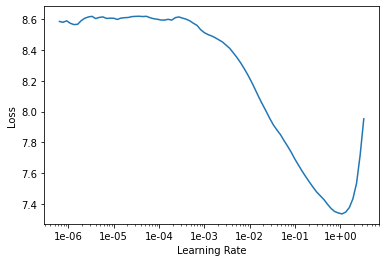

In [9]:
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,7.667972,6.207889,0.118810,00:01
1,6.593246,5.653549,0.136845,00:01
2,6.020299,5.493556,0.143631,00:01
3,5.624973,5.435277,0.147917,00:01
4,5.348388,5.433071,0.147083,00:01


In [11]:
learn.save_encoder('fine_tuned_enc')

In [12]:
with open(canosp_root_path/"candidate_tags/all_methods_intersection") as f:
    candidate_tags = [line.strip() for line in f.readlines()]
    
# candidate_tags.remove("firefox")
    
label_cols = candidate_tags
label_cols

['tool',
 'link',
 'memory',
 'paste',
 'line',
 'app',
 'cookie',
 'order',
 'profile',
 'cpu',
 'code',
 'black',
 'word',
 'account',
 'support',
 'set',
 'button',
 'player',
 'card',
 'restore',
 'function',
 'date',
 'hard',
 'content',
 'dialog',
 'slow',
 'correctly',
 'sidebar',
 'run',
 'reader',
 'startup',
 'text',
 'aol',
 'edit',
 'website',
 'redirect',
 'keyboard',
 'image',
 'bing',
 'remember',
 'drag',
 'pop',
 'network',
 'trouble',
 'key',
 'info',
 'exception',
 'setup',
 'monitor',
 'access',
 'ubuntu',
 'play',
 'private',
 'auto',
 'prevent',
 'print',
 'launch',
 'close',
 'attachment',
 'language',
 'check',
 'mac',
 'microsoft',
 'disable',
 'dropdown',
 'previous',
 'background',
 'remove',
 'box',
 'color',
 'list',
 'time',
 'pdf',
 'change',
 'message',
 'security',
 'sync',
 'select',
 'page',
 'disappear',
 'live',
 'format',
 'file',
 'server',
 'reset',
 'start',
 'english',
 'block',
 'multiple',
 'flash',
 'home',
 'fail',
 'mail',
 'open',
 'mouse

In [13]:
test_datalist = TextList.from_df(test, cols='title_content', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='title_content', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols=label_cols , classes=label_cols)
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
xxbos constant crash hello ! i xxunk xxunk use the browser anymore . it xxunk xxunk i keep it open in background xxunk xxunk 1 tab or xxunk xxunk xxunk it . this xxunk xxunk xxunk xxunk xxunk 2017 xxunk year . i have xxunk the xxunk to this xxunk . thank you . - is the xxunk one xxunk xxunk xxunk i have xxunk to open the browser for,background;open;mozilla;crash;unable
xxbos firefox crash firefox crash time especially xxunk think video card go buy new video xxunk xxunk uninstalled firefox reinstall firefox disable addons disable hardware xxunk problem browser xxunk list submit crash report report would date xxunk xxunk xxunk 10 / 31 / 2019 8:42 xxunk xxunk xxunk xxunk xxunk 10 / 31 / 2019 8:42 xxunk xxunk xxunk xxunk 10 / 31 / 2019 8:42 pmbp xxunk xxunk xxunk,memory;load;crash;stop;facebook
xxbos xxunk update xxunk complex session invoke automatic refresh create old firefox datum folder desktop change firefox setting today xxunk update xxunk complex session invoke automatic refresh create old firefox datum folder desktop change firefox setting window 10 pro 64-bit update present operation normal stable subject event minimize browser work email client thunderbird firefox default click link thunderbird normally xxunk come pass click click double click link xxunk xxunk xxunk,auto;change;refresh;session
xxbos firefox crash time pull tab new screen run 4 screen linux mint currently xxunk geforce gt 730 pcie xxunk nvidia xxunk xxunk xxunk ons xxunk xxunk en xxunk en xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk request xxunk xxunk invalid window parameter 3 request xxunk linux mint 18.3 xxunk xxrep 8 0 xxunk xxunk xxunk xxunk xxunk request xxunk xxunk invalid window parameter,window;display;screen;crash;video
xxbos firefox 63 xxunk w / xxunk background xxunk 63.0.3 xxunk add tab close button hover color background necessarily w x xxunk inactive button transparent background fine like inactive x close tab right end necessarily easy xxunk red background hover state need close tab tab right end well easy target close issue solution inactive button transparent bg xxunk xxunk far hover color background size inactive button distort x red background,button;close;background


In [14]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()

In [15]:
learn_classifier.lr_find()

epoch,train_loss,valid_loss,time
0,0.737469,#na#,00:03
1,0.686358,#na#,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


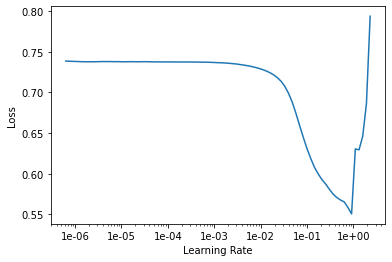

In [16]:
learn_classifier.recorder.plot()

In [17]:
learn_classifier.fit_one_cycle(6, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.553228,0.174284,00:04
1,0.217387,0.074323,00:04
2,0.125620,0.071043,00:04
3,0.091782,0.069944,00:04
4,0.077397,0.068500,00:04
5,0.070712,0.068342,00:04


In [18]:
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.070973,0.070700,00:04


In [19]:
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.068766,0.069247,00:04


In [20]:
learn_classifier.show_results(rows=1000)

text,target,prediction
xxbos work mozilla firefox xxunk sabotage xxunk iran www.blib.ir xxunk log kill work xxunk authorize sodomy communist mainly gypsy atheist etc disbeliever terrorist hell iran force target xxunk xxunk compel xxunk authorize terrorist rule iranians iran intentionally xxunk torture till present time 01 / xxunk / 2015 trap force alike terrorist mainly terrorist xxunk xxunk alike slave rule iranians inhumane gypsy xxunk xxunk inhumane terrorist disbeliever atheist communist xxunk xxunk,server,
xxbos firefox crash start error show firefox developer edition update xxunk restart update click firefox icon firefox process task manager time quit show window error message try enter safe mode press shift start firefox result process quit show dialog enter safe mode try uninstall install firefox result remove profile xxunk appdata% \ mozilla \ firefox \ profiles \ record window log start attempt < event xxunk = window error report,app;crash;program,
"xxbos nie xxunk potencjalne zagrożenie bezpieczeństwa xxunk problem z xxunk xxunk z xxunk youtube.com nie xxunk xxunk xxunk z xxunk xxunk xxunk o xxunk xxunk xxunk xxunk xxunk . xxunk xxunk xxunk i xxunk xxunk : potencjalne zagrożenie bezpieczeństwa xxunk : xxunk xxunk xxunk strony : firefox xxunk potencjalne zagrożenie bezpieczeństwa i nie xxunk "" www.youtube.com xxunk xxunk xxunk xxunk xxunk . xxunk xxunk w xxunk xxunk ? xxunk """,security;certificate;youtube,
xxbos need add on old version firefox not update browser not buy new hardware help xxunk xxunk people xxunk xxunk xxunk and xxunk xxunk not buy new and xxunk computer hardware xxunk firefox force us to use new hardware xxunk new version need new hardware and new add - ons need new version browser ... it is xxunk xxunk xxunk add - ons do for us xxunk you force us,mozilla,
xxbos get 2 email firefox personal information get hack sell recently get 2 email firefox state person information hack firefox sell email xxunk email 1 firefox monitor firefox monitor report report date december 6 2018 email address delete email address xxunk account involve datum breach recently report datum breach contain email follow datum xxunk breach date october 5 2018 compromise xxunk compromise datum email address xxunk xxunk location job title,information,email
xxbos computer crash selective power failure firefox tab refuse completely load computer lose power selective power failure currently sure blow xxunk reboot computer connect power cable outlet work currently power original outlet outlet area selective area xxunk boot firefox set reopen tab view shutdown restart crash notice take long load usual account large numb tab constantly open load access tab click highlight xxunk thing show white screen actual site include,file;html;load;homepage;google;restart;search;recover;crash;session;scroll,
xxbos firefox change default paper size printer select hello little background info deal work store xxunk xxunk share printer star xxunk printer brother size paper printer xxunk work issue able print system specific default printer setting change printer good issue xxunk xxunk star xxunk printer set print xxunk select brother printer drop menu switch star xxunk default paper size force letter cause xxunk print like large xxunk paper mean portion,change;size;default;wrong;printer,
xxbos start happen hour firefox year experience xxunk hour browse firefox xxunk halt try suggestion work large numb tab regularly family history research move web site time xxunk information capture screen shot xxunk update datum ancestry xxunk particularly switch program regularly e.g. photoshop element xxunk word retire programmer xxunk web site developer wonder browser activity index tab refresh tab hour xxunk way disable activity want happen annoy waste xxunk time,crash,
xxbos xxunk tool view lose session tab xxunk try restore lose tab window hello xxunk firefox version 65.0.2 try tool view tab firefox profile file not think work drag file click xxunk button bunch xx

In [50]:
ticket_dict = {}

with open(data_path/"mturk_tickets.json", "r") as f:
    tickets = json.loads(f.read())["tickets"]
    for ticket in tickets:
        ticket_dict[str(ticket["ticket_id"])] = ticket

In [51]:
import csv

pred_threshold = 0.1

preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = preds.numpy()

In [52]:
# create CSV writer
csv_file = open(data_path/"class_output.csv", "w", newline="")
csv_writer = csv.writer(csv_file, delimiter=",")

# write the CSV header
# ticket_id end_time judgement_id start_time tagger_id tags
csv_columns = ["ticket_id", "title", "content", "pred_tags"]
csv_writer.writerow(csv_columns)

for i in range(len(test_datalist.items)):
    ticket_id = str(test_id[i])
    tags = []
    for j in range(len(candidate_tags)):
        if labels[i][j] > pred_threshold:
            tags.append(candidate_tags[j])
            
#     print("ID:", ticket_id)
#     print("Title:", ticket_dict[ticket_id]["title"])
#     print("Content:", ticket_dict[ticket_id]["content"])
#     print("Tags:", ", ".join(tags))
#     print()
    
    csv_row = [ticket_id, ticket_dict[ticket_id]["title"], ticket_dict[ticket_id]["title"], ",".join(tags)]  
    csv_writer.writerow(csv_row)
            
csv_file.close()

In [53]:
class_results = pd.read_csv(data_path/"class_output.csv")
class_results

,ticket_id,title,content,pred_tags
0,1277566,Parts of Ancestry.co.uk no longer working with...,Parts of Ancestry.co.uk no longer working with...,NaN
1,1277571,Which Firefox profile should I back up ?,Which Firefox profile should I back up ?,"sync,version"
2,1277593,Firefox is loading sites very slowly since the...,Firefox is loading sites very slowly since the...,NaN
3,1277664,How do I get firefox to log into websites auto...,How do I get firefox to log into websites auto...,"website,page,login"
4,1277700,"Unexpected behavior with ""jump to end of word""...","Unexpected behavior with ""jump to end of word""...","button,mac,page,address,default,bar,version,se..."
...,...,...,...,...
95,1280240,I downloaded a english dictionary for spellche...,I downloaded a english dictionary for spellche...,"print,language,change,sync,file,english,printe..."
96,1280265,The quick save bookmark star (to 3 dots) went ...,The quick save bookmark star (to 3 dots) went ...,"restore,toolbar"
97,1280314,Can someone help me with the PR_END_OF_FILE_ERROR,Can someone help me with the PR_END_OF_FILE_ERROR,"website,security,site,connection"
98,1280327,"Firefox 73.0.1 was working fine, suddenly all ...","Firefox 73.0.1 was working fine, suddenly all ...","version,crash"


In [59]:
tag_set = set(candidate_tags)
all_set = set()

for ticket in ticket_dict.values():
    for tagger, tags in ticket["tags"].items():
        if tagger != "0":
            for tag in tags:
                all_set.add(tag)

print(all_set)
print(tag_set)
print(tag_set - all_set)

{'thumbnails', '', 'keybord-functionality', 'dropping', ' signing', 'thepetitionsite.com', 'tan', 'new-feature-suggestion', 'navigating', 'selected', 'login.', 'address', 'limit', 'quick', 'disappeas', 'ctrl+f', 'firefoxerror', 'accessing', 'firefox-profile', ' title bar', ' lagging', 'chroe', 'errors', 'ubunt', 'dom2-', 'customized', 'mennu', 'browsers', 'decades', 'recognition', '72.0.2(64-bit)', 'dark-mode', 'functions', 'authenticate', 'attached-logs', 'control-panel', 'about:addons', 'cloudflare', ' themes', 'move-nav-bar', 'answer', 'autoscrollinwg-file-explorer', 'information-question', 'mail.live.com', 'multiple-user-accounts\n', 'submission', 'touch', 'bookmark-toolbar', 'not-showing', ' customize', 'outlook', 'mousewheel', 'zillow', 'protetion', 'issue\n', ' ad', 'disable', 'brother', 'awscloud9', 'tvguide', 'flashes', 'TLS', 'backuprestore', 'blocks', 'internal', 'password-recover', 'Add-on', 'solid', 'taskmanager', 'utf-8', 'become', 'n/a', 'analytic', 'allowed', 'restored'